# Exploring and comparing the EC tower data with gridded datasets

* Per-site, facet plots:
    * For common in-situ and gridded variables: Ta, VPD, rainfall, incoming solar
        * Correlation matrices
        * 1:1 plots with r2 and MAE
        * Distributions
* Group all sites together
    * Distributions 

     

## Load modules

In [1]:
import os
import scipy as sp
import numpy as np
import pandas as pd
import seaborn as sb
import xarray as xr
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error


## Analysis parameters

In [2]:
path = '/g/data/os22/chad_tmp/NEE_modelling/results/training_data/'

First, stitch all the training data together add site name as field 

In [3]:
dffs = []
for i in os.listdir(path):
    if 'csv' in i:
        df = pd.read_csv(path+i,index_col='time', parse_dates=True)
        df['site_name'] = i[0:3]
        dffs.append(df)

df = pd.concat(dffs)

##  1:1 point-to-pixel comparisons

Function for producing nice 1:1 plots grouped by a variable in the dataframe

In [ ]:
def one_to_one(df, x, y, groupby_var, title, col_wrap, adjust, output_path, ax_lim=(None,None)):
    df = df[[x, y, groupby_var]].dropna()
    fg = sb.FacetGrid(df, col=groupby_var, col_wrap=col_wrap, margin_titles=True)
    fg.map(sb.scatterplot,x,y,color="#338844", edgecolor="white", s=50, lw=1, alpha=0.5)
    fg.map(sb.regplot, x, y, scatter=False, color='m')
    fg.map(sb.regplot, x, x, scatter=False, color='black', line_kws={'linestyle':'dashed'})
    fg.set(ylim=ax_lim, xlim=ax_lim)
    fg.set_axis_labels("In-situ", "Gridded")

    def annotate(data,**kws):
        r, p = sp.stats.pearsonr(data[x], data[y])
        mae = mean_absolute_error(data[x], data[y])
        ax = plt.gca()
        ax.text(.05, .8, 'r={:.3f}'.format(r),
                transform=ax.transAxes)
        ax.text(.05, .7, 'mae={:.3g}'.format(mae),
                transform=ax.transAxes)

    fg.map_dataframe(annotate)
    fg.fig.subplots_adjust(top=adjust)
    fg.fig.suptitle(title)
    plt.savefig(output_path);

Site specific 1:1 plots

In [ ]:
one_to_one(df,
           x='Precip_EC',
           y='precip_RS',
           groupby_var='site_name',
           title=f'Rainfall (mm)', #W/m\N{SUPERSCRIPT TWO}
           col_wrap=5,
           ax_lim=(0,400),
           adjust=0.935, 
           output_path='/g/data/os22/chad_tmp/NEE_modelling/results/figs/one_to_one/precip_site_name.png'
          )


Group by simplified landcover class

In [ ]:
one_to_one(df,
           x='Precip_EC',
           y='precip_RS',
           groupby_var='IGBP_class_RS',
           title=f'Rainfall (mm)', #W/m\N{SUPERSCRIPT TWO},
           ax_lim=(0,500),
           col_wrap=3,
           adjust=0.8,
           output_path='/g/data/os22/chad_tmp/NEE_modelling/results/figs/one_to_one/precip_IGBP.png'
          )

---

## Compare insitu distributions (EC data) with remotely sensed distributions (Aus-wide)

### First prepare the EC data

In [4]:
ec_vars = df.filter(regex='EC').drop(['NEE_SOLO_EC', 'GPP_SOLO_EC', 'ER_SOLO_EC', 'RH_EC', 'Sws_EC', 'Fe_EC', 'Fn_EC', 'Fh_EC', 'Fld_EC'],
                                     axis=1).rename({'Ta_EC':'Ta', 'Precip_EC':'precip','Fsd_EC':'Fsd','VPD_EC':'VPD'},axis=1).reset_index(drop=True)
ec_vars.head()
ec_vars['Measurement'] = 'EC'

### Gather the gridded data over all of Aus

Extract a random subsample of data to keep compute down

In [5]:
f = 1
t1,t2 = '2020', '2021'
#temperature
print('Sampling Ta')
ta_rs = xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/data/AWRA/tavg_monthly_1991_2021.nc')
ta_rs = ta_rs.rename({'temp_avg_month':'Ta'})
ta_rs = ta_rs.sel(time=slice(t1, t2))
ta_rs = ta_rs.Ta.to_dataframe().reset_index(
        level=[1, 2]).drop(['latitude', 'longitude'], axis=1).sample(frac=f).reset_index(drop=True)
ta_rs['Measurement'] = 'RS'

# shrtwave radiation
print('Sampling solar radiation')
solar = xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/data/AWRA/solar_monthly_wm2_2000_2021.nc')
solar = solar.rename({'solar_exposure_day':'Fsd'})
solar = solar.sel(time=slice(t1, t2))
solar = solar.Fsd.to_dataframe().reset_index(
        level=[1, 2]).drop(['latitude', 'longitude', 'spatial_ref'], axis=1).sample(frac=f).reset_index(drop=True)
solar['Measurement'] = 'RS'

#rainfall
print('Sampling Rainfall')
rain = xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/data/chirps_aus_monthly_1991_2021.nc')
rain = rain.sel(time=slice(t1,t2))
rain = rain.precip.to_dataframe().reset_index(
        level=[1, 2]).drop(['latitude', 'longitude', 'spatial_ref'], axis=1).sample(frac=f).reset_index(drop=True)
rain['Measurement'] = 'RS'

#vapour pressure deficit
print('Sampling VPD')
vpd = xr.open_dataset('/g/data/os22/chad_tmp/NEE_modelling/data/AWRA/vpd_monthly_2000_2021.nc')
vpd = vpd.sel(time=slice(t1, t2))
vpd = vpd.VPD.to_dataframe().reset_index(
        level=[1, 2]).drop(['latitude', 'longitude', 'spatial_ref'], axis=1).sample(frac=f).reset_index(drop=True)
vpd['Measurement'] = 'RS'

Sampling Ta
Sampling solar radiation
Sampling Rainfall
Sampling VPD


### Join EC and remote sensing data, then wrangle into individual dataframes

In [7]:
df = pd.concat([ec_vars, ta_rs, solar, rain, vpd])

ta = df[['Ta', 'Measurement']].melt(id_vars=['Measurement'], var_name='Ta').dropna().reset_index(drop=True)
vpd = df[['VPD', 'Measurement']].melt(id_vars=['Measurement'], var_name='VPD').dropna().reset_index(drop=True)
precip = df[['precip', 'Measurement']].melt(id_vars=['Measurement'], var_name='precip').dropna().reset_index(drop=True)
precip = precip[precip.value < 300]
solar = df[['Fsd', 'Measurement']].melt(id_vars=['Measurement'], var_name='Fsd').dropna().reset_index(drop=True)

### Create violin plots

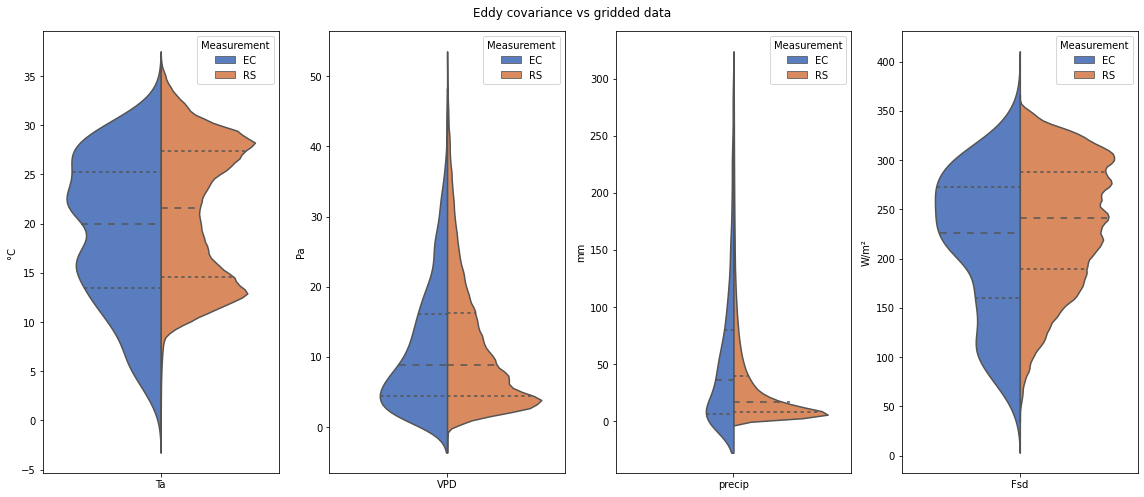

In [8]:
fig, ax = plt.subplots(1, 4, figsize=(16,7), sharey=False, sharex=False)
sb.violinplot(x="Ta", y="value", hue="Measurement", ax=ax[0], data=ta, palette="muted", split=True, inner="quartile", scale='width')
sb.violinplot(x="VPD", y="value", hue="Measurement", ax=ax[1], data=vpd, palette="muted", split=True,inner="quartile")
sb.violinplot(x="precip", y="value", hue="Measurement", ax=ax[2], data=precip, palette="muted", split=True, inner="quartile")
sb.violinplot(x="Fsd", y="value", hue="Measurement", ax=ax[3], data=solar, palette="muted", split=True, inner="quartile");

degree_sign = u'\N{DEGREE SIGN}'
units = [degree_sign+'C', 'Pa', 'mm', f'W/m\N{SUPERSCRIPT TWO}']

for i,j in zip(ax, units):
    i.set_ylabel(j)
    i.set_xlabel('')
plt.suptitle('Eddy covariance vs gridded data')
plt.tight_layout()
plt.savefig('/g/data/os22/chad_tmp/NEE_modelling/results/figs/ec_vs_rs_violinplots.png');

---
## Correlation matrices

In [ ]:
def corr_matrix_ec(df, groupby_var, suffix, drop, col_wrap, output_path, height=4, aspect=1):
    df = df.filter(regex=r'(_EC|site)').drop(drop,axis=1)
    df = df.sort_values('site_name')
    df.columns = df.columns.str.rstrip(suffix)
    df = df.rename({'NEE_SOLO':'NEE', 'GPP_SOLO':'GPP', 'ER_SOLO':'ER'}, axis=1)
    fg = sb.FacetGrid(df, col=groupby_var, col_wrap=col_wrap, sharex=False, height=height, aspect=aspect)
    fg.map_dataframe(lambda data, color: sb.heatmap(data.corr(),vmin=-1.0, vmax=1.0,annot=True, cbar=False,  cmap="bwr_r", mask=np.triu(np.ones_like(data.corr(), dtype=bool))))
    plt.savefig(output_path);
    
corr_matrix_ec(df=df,       
           suffix='_EC',
           drop=['Fe_EC','Fh_EC','Fld_EC', 'Sws_EC', 'RH_EC','Fn_EC'],
           groupby_var='site_name',
           col_wrap=6,
           output_path='/g/data/os22/chad_tmp/NEE_modelling/results/figs/corr_ec.png'
           )

In [ ]:
def corr_matrix_rs(df, groupby_var, suffix, drop, col_wrap, output_path, height=4, aspect=1):
    df = df.set_index(['site_name'], append=True)
    fluxes = df[['NEE_SOLO_EC', 'GPP_SOLO_EC','ER_SOLO_EC']]
    df = df.filter(regex=r'(_RS|site)').drop(drop,axis=1)
    df = df[['Ta_RS','precip_RS','solar_RS', 'VPD_RS']] # reorder to match EC order
    df = fluxes.join(df)
    df = df.reset_index(level=[1])
    df = df.sort_values('site_name')
    df.columns = df.columns.str.rstrip(suffix)
    df = df.rename({'NEE_SOLO_EC':'NEE', 'GPP_SOLO_EC':'GPP', 'ER_SOLO_EC':'ER', 'solar':'Fsd'}, axis=1)
    fg = sb.FacetGrid(df, col=groupby_var, col_wrap=col_wrap, sharex=False, height=height, aspect=aspect)
    fg.map_dataframe(lambda data, color: sb.heatmap(data.corr(), vmin=-1.0, vmax=1.0, annot=True, cbar=False,  cmap="bwr_r", mask=np.triu(np.ones_like(data.corr(), dtype=bool))))
    plt.savefig(output_path);
    
corr_matrix_rs(df=df,       
           suffix='_RS',
           drop=['lai_RS', 'LST_RS', 'Fpar_RS', 'soil_moisture_RS', 'LST-Tair_RS','spei_RS','precip_cml_RS', 'IGBP_class_RS'],
           groupby_var='site_name',
           col_wrap=6,
           output_path='/g/data/os22/chad_tmp/NEE_modelling/results/figs/corr_rs.png'
           )

In [ ]:
corr = df.filter(regex='EC').drop(['Fe_EC','Fh_EC','Fld_EC', 'Sws_EC', 'RH_EC','Fn_EC'],axis=1).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
fig,ax=plt.subplots(1,1, figsize=(8,8))
sb.heatmap(corr, cmap="bwr_r", annot=True, ax=ax, cbar=False, mask=mask)
plt.title('Correlations between CO2 fluxes and in-situ climate variables');

In [ ]:
fluxes = df[['NEE_SOLO_EC', 'GPP_SOLO_EC','ER_SOLO_EC']]
rs = df.filter(regex='RS')

In [ ]:
rs.columns

In [ ]:
corr = fluxes.join(rs).drop(['lai_RS', 'LST_RS', 'Fpar_RS', 'soil_moisture_RS', 'LST-Tair_RS','spei_RS','precip_cml_RS'],axis=1).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
fig,ax=plt.subplots(1,1, figsize=(10,10))
sb.heatmap(corr, cmap="bwr_r", annot=True, ax=ax, cbar=False, mask=mask)
plt.title('Correlations between CO2 fluxes and gridded climate variables');